# Modules

In [1]:
# Packages import
# Required packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pyDOE as doe
import sklearn.gaussian_process.kernels as skl
import pymc3 as pm
import theano.tensor as tt
import theano
import time
import seaborn as sns
from tqdm import tqdm
import sys
import psutil
import os
import shutil
import copy
from matplotlib import gridspec
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp

# Funciton Defs. - Utilities

In [2]:
#### The functions below are directly coppied from Variational_calibration
##### Run this block before any simulation #####
def input_locations(d_input, n_input, lims, criterion = "c"): 
    """Simulation inputs generator
    
    The function generates inputs for model/observations according to latin hypercube design or uniform design
    within given range and dimension of inputs
    
    Args:
        d_input: The dimension of inputs to be generated
        n_input: The number of inputs
        lims: Ndarray with the range of inputs for each variable , each row is limits for each var
        criterion: "m", "c" for lating hypercube, "uniform" for uniform design
        
    Returns:
        inputs: n_input * d_input Ndarray with generated input points.
    """
    if criterion == "uniform":
        inputs = []
        for i in range(d_input):
            inputs = inputs + [np.linspace(lims[i, 0], lims[i, 1], int(n_input ** (1 / d_input)))]
            
        grid_list = np.meshgrid(*inputs)
        
        inputs = np.zeros((n_input, d_input))
        for i in range(d_input):
            inputs[:,i] = grid_list[i].flatten()        
        
    else:
        # Data generation
        inputs = doe.lhs(d_input, samples = n_input, criterion = criterion)

        # Transformation for the interval
        for i in range(d_input):
            inputs[:,i] = inputs[:,i] * (lims[i,1] - lims[i, 0]) + lims[i, 0]

    return inputs

def gp_mean_cov(input_obs, input_m, d_input, theta, kernels, means):
    """The function generates the mean and convariance function of the prior GP that is 
    to be used for triaining data generation of observations Y and model evaluations Z according to
    Kennedy & O'Hagan (2001) framework to calibration.
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels["f"]
    K_base = kernel_base(kernel_input)
    
    # Model discrepancy kernel
    if kernels["delta"] != 0:
        
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros])
        K_delta = kernels["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
    # Add noise to the observations
    K = K_base + np.diag([kernels["sigma"] ** 2] * input_obs.shape[0] + [0] * input_m.shape[0])
    
    ##### Means part

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means["f"](elem[:d_input], elem[d_input:]) + means["delta"](elem[:d_input]))
    
    # Model mean
    m_mean = np.array([])
    for elem in input_m:
        # First input to mean is x, second input is theta
        m_mean = np.append(m_mean, means["f"](elem[:d_input], elem[d_input:]))

    M = np.concatenate((obs_mean, m_mean))
    
    return M, K

##### Distribution family classes that are used as 1) Variational fmailies, 2) Overdispersed familiees, 3) Priors
# Each class contains the following methods:
#
# __init__(self, param, init)
#
# sample(self, n_size)
#
# log_pdf(self, theta)
#
# log_grad_pdf(self, theta)

class gaussian_mean_field_family:
    """Class for a mean field gaussian family of arbitrary dimension"""
    
    def __init__(self, param, dim):
        """The parameters for the Gaussian mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the np.log(SDs) of independent Gaussian distributions
            dim: dimension of the family
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = self.sigma[i], size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            density = sp.stats.norm(loc = self.mu[i], scale = self.sigma[i])
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t mu and gradient[dim:] are the values of score function w.r.t sigma
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):
            # score function w.r.t. mean
            gradient[i] = (theta[i] - self.mu[i]) / (self.sigma[i] ** 2)
            # score function w.r.t. SD
            gradient[i + self.dim] = - 1 / self.sigma[i] + ((theta[i] - self.mu[i]) ** 2) / (self.sigma[i] ** 3)
        return gradient
    
class gamma_mean_field_family:
    """Class for a mean field gamma family of arbitrary dimension with np.log(param) parametrization
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sample[:, i] = np.random.gamma(shape = self.alpha[i], scale = self.beta[i], size = n_size)
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            log_dens = log_dens + (self.alpha[i] - 1) * np.log(theta[i]) - theta[i] / self.beta[i] - self.alpha[i] * np.log(self.beta[i]) - np.log(sp.special.gamma(self.alpha[i]))
    
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            # score function w.r.t. alpha
            gradient[i] = np.log(theta[i]) - np.log(self.beta[i]) - sp.special.digamma(self.alpha[i])
            # score function w.r.t. beta
            gradient[i + self.dim] = theta[i] / (self.beta[i] ** 2) - self.alpha[i] / self.beta[i]
        return gradient
    
class gaussian_mean_field_family_lambda_param:
    """Class for a mean field gaussian family of arbitrary dimension with scale parametrization 
    
    lambda = log(exp(sigma) - a)
    
    """
    def __init__(self, param, dim):
        """The parameters for the Gaussian mean field family aare passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the transformed sd of independent Gaussian distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = sd, size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            density = sp.stats.norm(loc = self.mu[i], scale = sd)
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t mu and gradient[dim:] are the values of score function w.r.t sigma
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):
            # score function w.r.t. mean
            gradient[i] = - (self.mu[i] - theta[i]) / (np.log(np.exp(self.sigma[i]) + self.a) ** 2)
            # score function w.r.t. lambda
            gradient[i + self.dim] = np.exp(self.sigma[i]) * (- 1 / (np.log(self.a + np.exp(self.sigma[i])) * (self.a + np.exp(self.sigma[i]))) + \
                                                             ((self.mu[i] - theta[i]) ** 2) / ((self.a + np.exp(self.sigma[i])) * np.log(self.a + np.exp(self.sigma[i])) ** 3))
        return gradient

    
class gamma_mean_field_family_lambda_param:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    
    
    lambda_alfa = log(exp(alfa) - a)
    lambda_beta = log(exp(alfa) - a)
    
    where alpha corresponds to the mean of the gamma distribution and beta corresponds to the std of the gamma dist
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the mean paramteres of the independent Gamma distribution
                 - param["beta"] is a 1-dim Ndarray with the stds of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            l_m = self.alpha[i]
            l_s = self.beta[i]
            # score function w.r.t. lambda_alpha
            g1m = (np.log(self.a + np.exp(l_s)) ** 2) * (self.a + np.exp(l_m))
            g2m = np.log(self.a + np.exp(l_m))
            gradient[i] = (np.exp(l_m) * g2m - theta[i] * np.exp(l_m) - 2 * np.exp(l_m) * sp.special.digamma((g2m / np.log(self.a + np.exp(l_s))) ** 2) + \
                          2 * np.exp(l_m) * np.log(theta[i]) * g2m + 2 * np.log(g2m / (np.log(self.a + np.exp(l_s)) ** 2)) * np.exp(l_m) * g2m) / g1m
            
            # score function w.r.t. lambda_beta
            g1l = (np.log(self.a + np.exp(l_s)) ** 3) * (self.a + np.exp(l_s))
            g2l = np.log(self.a + np.exp(l_m)) ** 2
            gradient[i + self.dim] = (2 * np.exp(l_s) * sp.special.digamma(g2l / (np.log(self.a + np.exp(l_s)) ** 2)) * g2l - \
                                     2 * np.log(np.log(self.a + np.exp(l_m)) / (np.log(self.a + np.exp(l_s)) ** 2)) * np.exp(l_s) * g2l -\
                                     2 * np.exp(l_s) * g2l - 2 * np.exp(l_s) * np.log(theta[i]) * g2l + 2 * theta[i] * np.exp(l_s) * np.log(self.a + np.exp(l_m))) / g1l
        return gradient
    

class gamma_mean_field_family_ms:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    
    Directly parametrized no transformation here
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            # score function w.r.t. np.log(alpha)
            l_m = self.alpha[i]
            l_s = self.beta[i]
            
            gradient[i] = (l_m - theta[i] + 2 * l_m * np.log(theta[i]) + 2 * l_m * np.log(l_m / (l_s ** 2)) - 2 * l_m * sp.special.digamma((l_m/l_s) ** 2)) / (l_s ** 2)
    
            gradient[i + self.dim] = 2 * (l_m * theta[i] - l_m ** 2 + sp.special.digamma((l_m/l_s)** 2) * l_m ** 2 - np.log(theta[i]) * l_m ** 2 - np.log(l_m / (l_s ** 2)) * l_m **2) / (l_s ** 3)
        return gradient
    
class gamma_mean_field_family_ms_overdisp:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    directly
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim, tau):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
            tau: Dispersion coefficient >= 1
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf_tau(self, theta):
        """Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        gradient = np.zeros(self.dim)
        for i in range(self.dim):    
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            
            gradient[i] = (self.tau[i] * np.log(beta / self.tau[i]) - (alpha + self.tau[i] - 1) + beta * theta[i] - \
                          np.log(beta / self.tau[i]) * (alpha + self.tau[i] - 1) + sp.special.digamma((alpha + self.tau[i] - 1) /self.tau[i]) * (alpha - 1) - \
                          np.log(theta[i]) * (alpha - 1)) / self.tau[i]      
        return gradient
   
    
class gaussian_mean_field_family_lambda_param_overdisp:
    """Class for a mean field overdispersed gaussian family of arbitrary dimension with scale parametrization 
    
    lambda = log(exp(sigma) - a)
    
    """
    def __init__(self, param, dim, tau):
        """The parameters for the Gaussian mean field family aare passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the np.log(SDs) of independent Gaussian distributions
                 - param["a"] see parametrization 
            dim: Dimension of the family
            tau: Dispersion coefficient >= 1
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a) * np.sqrt(self.tau[i])
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = sd , size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a) * np.sqrt(self.tau[i])
            density = sp.stats.norm(loc = self.mu[i], scale = sd)
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf_tau(self, theta):
        """"Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        gradient = np.zeros(self.dim)
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            gradient[i] = - 1/(2 * self.tau[i]) + (((theta[i] - self.mu[i]) / (self.tau[i] * sd)) ** 2) / 2
            
        return gradient

class gamma_mean_field_family_lambda_param_overdisp:
    """Class for a mean field overdispersed gamma family of arbitrary, parametrized with mean and standard deviation
    
        lambda_alfa = log(exp(alfa) - a)
        lambda_beta = log(exp(alfa) - a)
    
        where alpha corresponds to the mean of the gamma distribution and beta corresponds to the std of the gamma dist
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim, tau):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see above
            tau: Overdispersion parameter value
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    
    def grad_log_pdf_tau(self, theta):
        """"Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        
        gradient = np.zeros(self.dim)
        for i in range(self.dim):    
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2)
            beta = float(mu/ (sigma**2))
            
            gradient[i] = (self.tau[i] * np.log(beta / self.tau[i]) - (alpha + self.tau[i] - 1) + beta * theta[i] - \
                          np.log(beta / self.tau[i]) * (alpha + self.tau[i] - 1) + sp.special.digamma((alpha + self.tau[i] - 1) /self.tau[i]) * (alpha - 1) - \
                          np.log(theta[i]) * (alpha - 1)) / self.tau[i]      
        return gradient
##### END of distribution class definition


##### GP model means class definintions    
class delta_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of model discrepancy GP
        
        Args:
            hyperparameters: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x):
        """Zero mean: m(x) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
        Returns: 0
        """
        return 0
    
    def constant(self, x):
        """Constant mean: m(x) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def linear(self, x):
        """Linear mean: m(x) =Intercept + \Beta * x^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], x)
        return mean
    
    
class model_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of computer model GP
        
        Args:
            hyperparameters: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x, theta):
        """Zero mean: m(x,theta) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters  
        Returns: 0
        """
        return 0
    
    def constant(self, x, theta):
        """Constant mean: m(x,theta) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def dot_product(self, x, theta):
        """Dot product mean, for two dimensional model input x as defined in the 
           simulation setup in Kejzlar and Maiti (2020): 
           
           m(x,theta) = \Beta * (\theta_1 * cos(x_1) + \theta_2 * cos(x_2))
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        if x.ndim == 1:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[0]), np.sin(x[1])]), theta)
        else:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[:,0]), np.sin(x[:,1])]), theta)
##### END of GP model means class definitnon

# MCMC Bayesian Calibration - Simulation

In [3]:
##### This block contains code to carry out the MCMC calibration to the Simulation study,
# the code for variational approaches is in Variational_calibration.ipynb notebook

# Generating the training data and defining prior distributions 
priors_dictionary = {}
theta_dim = 2
ns = 30 #Numerators for eta_f and eta_delta
tf.random.set_seed(123)
np.random.seed(123)

### Theta prior
mean_theta = np.array([0.5,0.5])
cov_theta = np.array([1/10,1/10])
dim = theta_dim
theta_prior = gaussian_mean_field_family(param = {"mu": mean_theta, "sigma": cov_theta}, dim = dim)
theta = theta_prior.sample(1).flatten() # The true theta value as a sample from prior distribution
priors_dictionary["theta"] = theta_prior

### Noise prior
alpha = np.array([1])
beta = np.array([1/80])
dim = 1
noise_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
noise = np.array([0.01]) # Noise value for simulation
priors_dictionary["sigma"] = noise_prior

### Kernel f hyperparameters priors
## length scales
alpha = np.array([1])
beta = np.array([20])
beta = np.array([1/4])
dim = 1
kernel_f_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_f_l = 1 # true value of length scale
priors_dictionary["kernel_f_l"] = kernel_f_l_prior
## eta
alpha = np.array([1])
beta = np.array([1/40])
dim = 1
kernel_f_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_f_eta = 1/ns # true value of eta_f
priors_dictionary["kernel_f_eta"] = kernel_f_eta_prior

### Kernel delta hyperparameters priors
## length scales
alpha = np.array([1])
beta = np.array([1/4])
dim = 1
kernel_delta_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_delta_l = 1/2 # true vaule of lenght scale
priors_dictionary["kernel_delta_l"] = kernel_delta_l_prior

## eta
alpha = np.array([1])
beta = np.array([1/40])
dim = 1
kernel_delta_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_delta_eta = 1/ns # true value of delta_eta
priors_dictionary["kernel_delta_eta"] = kernel_delta_eta_prior

### Mean f hyperparameters
f_beta = 1

### Mean delta hyperparameters
mean_beta = np.array([0])
cov_beta = np.array([1/4])
dim = 1
mean_delta_prior = gaussian_mean_field_family(param = {"mu": mean_beta, "sigma": cov_beta}, dim = dim)
delta_beta = 0.15 # true value of beta
priors_dictionary["mean_delta"] = mean_delta_prior

##### Kernel definition
# f kernel
kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
kernel_type = list(kernel)[0]
if kernel_type == "sq_quad":
    kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       
    
if kernel_type == "matern": # option for mattern kernel
    kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.Matern(length_scale = kernel[kernel_type][1],
                                                               nu = kernel[kernel_type][2])
# delta kernel
kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
kernel_type = list(kernel)[0]
if kernel_type == "sq_quad":
    kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       
    
if kernel_type == "matern":
    kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.Matern(length_scale = kernel[kernel_type][1],
                                                               nu = kernel[kernel_type][2])
if kernel_type == "zero":
    kernel_delta = 0
    
# Kernels input 
kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
model_hyperparameters = {"Beta": float(f_beta)}
delta_hyperparameters = {"Beta": float(delta_beta)}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)

means_input = {"f": f_mean_init.dot_product, "delta": delta_mean_init.constant}
means = {"f": f_mean_init.dot_product, "delta": "constant" }

#### Data generation part
n_obs = 144 # set to 2500, 5000, 10000 for the scalability simulation
n_m = 81 # set to 2500, 5000, 10000 for the scalability simulation
n_average = 1
d_input = 2 # dimension of the variable input
tf.random.set_seed(123)
np.random.seed(123)
# For scalability simulation switch criterion = "c" for numerical stability
lims = np.array([[0, 3], [0, 3]])
input_obs = input_locations(d_input, n_obs, lims=lims, criterion = "uniform")
d_input = 2
lims = np.array([[0, 3], [0,3], [0, 1], [0, 1]])
input_m = input_locations(theta_dim + d_input, n_m, lims=lims, criterion = "uniform")
print(theta)

tf.random.set_seed(123)
np.random.seed(123)
# Mean and covariance functions for the training data
M, K = gp_mean_cov(input_obs, input_m, d_input, theta, kernels_input, means_input)
tfd = tfp.distributions
mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
Y_Z_tensor = mvn.sample(1)
Y_Z = Y_Z_tensor.numpy().flatten()
Y = Y_Z[:n_obs][:,None]
Z = Y_Z[n_obs:][:,None]

[0.39143694 0.59973454]


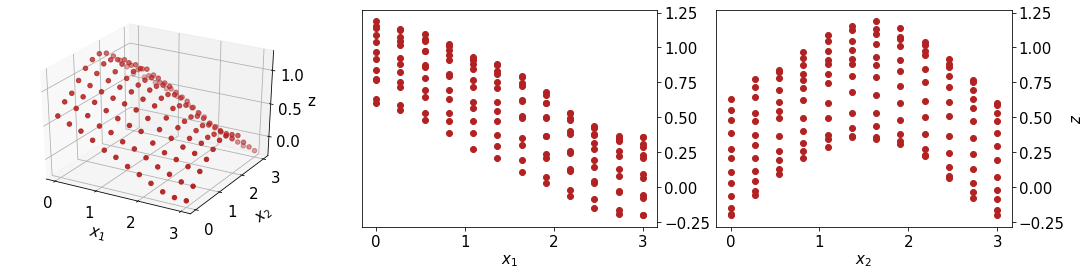

In [4]:
#### Formating data into a data_input dictionary format used for the VC_calibration_hyper functions
# This is independent from any GP specification or the type of variance reduction used

# index generating
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc. index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

########### This will be done in each stap of the sampling procedure but needs to be initialized to something
# Input values theta
theta_variational = theta
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_dim), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs

### Save the data_input dictionary as .pickle file
#with open(str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
#    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)
###

### Load the data_input dictionary from .pickle file
#with open(str(n_obs) + '_' + str(n_m) + "_" + str(lims[0][1]) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
###

####################### Optional - plots the generated model runs ####################
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(18, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
ax1 = plt.subplot(gs[0], projection='3d')
ax1.scatter(input_obs[:,0],input_obs[:,1], Y, c = 'firebrick')
ax1.set_xlabel(r'$x_1$', labelpad=10)
ax1.set_ylabel(r'$x_2$', labelpad=10)
ax1.set_zlabel(r'z')

ax2 = plt.subplot(gs[1])
ax2.scatter(input_obs[:,0], Y, c = 'firebrick')
ax2.set_xlabel(r'$x_1$')
ax2.yaxis.tick_right()
ax2.set_ylabel(r'$z$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot(gs[2])
ax3.scatter(input_obs[:,1], Y, c = 'firebrick')
ax3.set_xlabel(r'$x_2$')
ax3.yaxis.tick_right()
ax3.set_ylabel(r'$z$')
ax3.yaxis.set_label_position("right")

plt.show()
plt.show()
####################################################################################

In [5]:
##### Bayesian calibration using PyMC3
x_dim = 2
theta_dim = 2
np.random.seed(0)
# Preprocessing input
def observations_scale(x):
    return x[:, -1]

# Preprocessing all the shared data
obs_indicator = data_input["Response"][:,1][:,None]
X_obs_indicator = np.concatenate([data_input["X"][:,1:], obs_indicator], axis = 1)
X_shared = theano.shared(data_input["X"][:,1:])
theta_model_shared = theano.shared(input_m[:,x_dim:])
sampler_type = "MH" # "MH" or "NUTS"
n_tune = 1000 # Number of tuning samples
n_sample = 10000 # Number of effective samples

time_counter = np.array(time.monotonic())

with pm.Model() as full_bayes:
    
    ## Priors definition
    # Theta prior
    theta_random = pm.Normal("theta", mu = priors_dictionary["theta"].mu,
                        sd = priors_dictionary["theta"].sigma,
                        shape = priors_dictionary["theta"].dim)
    
    ## Noise Prior
    noise = pm.Gamma("sigma", alpha = float(priors_dictionary["sigma"].alpha),
                     beta = float(1/priors_dictionary["sigma"].beta))
    
    ### Kernel f hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_f_l"].dim > 1:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"].alpha),
                              beta = float(1/ priors_dictionary["kernel_f_l"].beta),
                              shape = priors_dictionary["kernel_f_l"].dim)
    else:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"].alpha),
                          beta = float(1 / priors_dictionary["kernel_f_l"].beta))
    ## eta
    kernel_f_eta = pm.Gamma("kernel_f_eta", alpha = float(priors_dictionary["kernel_f_eta"].alpha),
                            beta = float(1 / priors_dictionary["kernel_f_eta"].beta))
    
    ### Kernel delta hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_delta_l"].dim > 1:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = priors_dictionary["kernel_delta_l"].alpha,
                                  beta = 1/ priors_dictionary["kernel_delta_l"].beta,
                                  shape = priors_dictionary["kernel_delta_l"].dim)
    else:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = np.float(priors_dictionary["kernel_delta_l"].alpha),
                              beta = np.float(1 / priors_dictionary["kernel_delta_l"].beta))
    ## eta
    kernel_delta_eta = pm.Gamma("kernel_delta_eta", alpha = float(priors_dictionary["kernel_delta_eta"].alpha),
                                beta = float(1 / priors_dictionary["kernel_delta_eta"].beta))
    ## Means priors
    if "mean_f" in priors_dictionary:
        if priors_dictionary["mean_f"].dim > 1:
            mean_f = pm.Normal("mean_f", mu = priors_dictionary["mean_f"].mu,
                               sd = priors_dictionary["mean_f"].sigma,
                               shape = priors_dictionary["mean_f"].dim)
        else:
            mean_f = pm.Normal("mean_f", mu = float(priors_dictionary["mean_f"].mu),
                               sd = float(priors_dictionary["mean_f"].sigma))
            
        
    if "mean_delta" in priors_dictionary:
        if priors_dictionary["mean_delta"].dim > 1:
            mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"].mu,
                                   sd = priors_dictionary["mean_delta"].sigma,
                                   shape = priors_dictionary["mean_delta"].dim)
        else:
            mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"].mu),
                                   sd = float(priors_dictionary["mean_delta"].sigma))
        
    # Noise covariance
    cov_noise_base = pm.gp.cov.WhiteNoise(noise)
    cov_noise = pm.gp.cov.ScaledCov(1, cov_func = cov_noise_base, scaling_func = observations_scale)
    
    # Systematic discrepancy covariance
    if kernels["delta"] == "sq_quad":
        cov_delta_base = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(x_dim + 1, ls = kernel_delta_l,
                                                                   active_dims = [i for i in range(x_dim)])
    elif kernels["delta"] == "matern":
        print("matern kernel")
        
    cov_delta = pm.gp.cov.ScaledCov(x_dim + 1, cov_func = cov_delta_base, scaling_func = observations_scale)
    
    #Preprocessing theta
    thetas_variable = tt.concatenate([tt.tile(theta_random, (int(np.sum(obs_indicator)), 1)), theta_model_shared], axis = 0)
    X_thetas_variable = tt.concatenate([X_shared, thetas_variable], axis = 1)
    
    # Model covariance
    if kernels["f"] == "sq_quad":
        cov_f = kernel_f_eta ** 2 * pm.gp.cov.ExpQuad(x_dim + theta_dim, ls = kernel_f_l)
    elif kernels["f"] == "matern":
        print("matern kernel")
        
    # Complete covariance specification
    K = cov_f(X_thetas_variable) + cov_delta(X_obs_indicator) + cov_noise(obs_indicator)
    # Mean definition
    # Mean f
    if "mean_f" in priors_dictionary:
        if means["f"] == "constant":
            mu_f = mean_f * np.ones(len(data_input["Response"]))
        elif means["f"] == "dot_product":
            mu_f = mean_f * tt.diag(tt.dot(data_input["X"][:,1:], thetas_variable.T))
        elif means["f"] == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(mean_f, ones_X_thetas_variable.T)          
    else:
        if means["f"].__name__ == "zero":
            mu_f = 0 * obs_indicator.flatten()
        elif means["f"].__name__ == "constant":
            mu_f = f_mean_init.hyperparameters["Beta"] * np.ones(len(data_input["Response"]))
        elif means["f"].__name__ == "dot_product":
            mu_f = f_mean_init.hyperparameters["Beta"] * tt.diag(tt.dot(np.concatenate([np.cos(data_input["X"][:,1])[:,None], np.sin(data_input["X"][:,2])[:,None]], axis = 1), thetas_variable.T))
        elif means["f"].__name__ == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(np.array([f_mean_init.hyperparameters["Intercept"],f_mean_init.hyperparameters["Beta"]]).flatten(),
                          ones_X_thetas_variable.T)  
            
    # Mean delta
    if "mean_delta" in priors_dictionary:
        if means["delta"] == "constant":
            mu_delta = mean_delta * obs_indicator.flatten()
        elif means["delta"] == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(mean_delta, ones_X.T)  
    else:
        if means["delta"].__name__ == "zero":
            mu_delta = 0 * obs_indicator.flatten()
        elif means["delta"].__name__ == "constant":
            mu_delta = delta_mean_init.hyperparameters["Beta"] * obs_indicator.flatten()
        elif means["delta"].__name__ == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(np.array([delta_mean_init.hyperparameters["Intercept"],delta_mean_init.hyperparameters["Beta"]]).flatten(),
                              ones_X.T)  
        
            
    mu = mu_f + mu_delta    
    obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"][:,-1])
    if sampler_type == "MH":
        step = pm.Metropolis()
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, step = step, discard_tuned_samples = False)
    elif sampler_type == "NUTS":
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, discard_tuned_samples = False)
    # Saves trace    
    pm.backends.ndarray.save_trace(trace, "trace_" + str(n_obs) + "_" + str(n_m) + "_nsample_" 
                                   + str(n_sample) + "_sampler_" + sampler_type, overwrite=True)
# Saves time stamps
time_counter = np.append(time_counter, time.monotonic())
step_time = (time_counter[1] - time_counter[0]) / len(trace["sigma"])
time_counter = np.array([time_counter[0] + i * step_time for i in range(len(trace["sigma"]))])
np.save("time_nobs_" + str(n_obs) + '_' + str(n_m) + "_nsample_" + str(n_sample) + "_sampler_" + sampler_type, time_counter)

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mean_delta]
>Metropolis: [kernel_delta_eta]
>Metropolis: [kernel_delta_l]
>Metropolis: [kernel_f_eta]
>Metropolis: [kernel_f_l]
>Metropolis: [sigma]
>Metropolis: [theta]
Sampling chain 0, 0 divergences:   0%|                                                       | 0/11000 [00:00<?, ?it/s]C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

In [13]:
#### Loading precomputed results 

# Simulation - calibration
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_144_81_nsample_25000_sampler_MH")
    trace_NUTS = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_144_81_nsample_25000_sampler_NUTS")
# Simulation - scalability 5K
#with full_bayes:
#    trace = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_2500_2500_nsample_2000_sampler_MH")
#    trace_NUTS = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_2500_2500_nsample_1000_sampler_NUTS")
# Simulation - scalability 10K
#with full_bayes:
#    trace = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_5000_5000_nsample_500_sampler_MH")
#    trace_NUTS = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_5000_5000_nsample_150_sampler_NUTS")
# Simulation - scalability 20K
#with full_bayes:
#    trace = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_10000_10000_nsample_80_sampler_MH")
#    trace_NUTS = pm.backends.ndarray.load_trace("Simulation_results/Calibration/trace_10000_10000_nsample_80_sampler_NUTS")

In [11]:
pm.stats.summary(trace)

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_ut

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
theta[0]          0.391  0.014   0.367    0.418      0.000    0.000    3838.0   
theta[1]          0.614  0.022   0.574    0.656      0.001    0.000    1691.0   
mean_delta        0.136  0.015   0.107    0.162      0.000    0.000    2696.0   
sigma             0.010  0.001   0.009    0.012      0.000    0.000    7216.0   
kernel_f_l        0.920  0.051   0.819    1.009      0.001    0.001    2402.0   
kernel_f_eta      0.028  0.004   0.022    0.035      0.000    0.000    2347.0   
kernel_delta_l    0.503  0.053   0.406    0.601      0.001    0.001    1814.0   
kernel_delta_eta  0.035  0.007   0.024    0.048      0.000    0.000    1327.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
theta[0]          3537.0    5379.0    2884.0    NaN  
theta[1]          1691.0    2173.0    2299.0    NaN  
mean_delta        2467.0    2969.0    2715.0    NaN  
sigma             7051.0    7448.0    8672.0    NaN  
kernel_f_l        2376.0    2409.0    3884.0    NaN  
kernel_f_eta      2311.0    2439.0    3613.0    NaN  
kernel_delta_l    1564.0    2157.0    1642.0    NaN  
kernel_delta_eta   931.0    2163.0    1779.0    NaN

## Calibration results

In [74]:
#### Loading the 
n_obs = 144
#n_vc = 22798
n_vc = 23000
n_steps = 150000
S = 50
l =3
#l = 
vine_type = "D"
learning_rate = "AdaGrad"
eta = 0.07
decay = 1.0
folder = str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
                                    "_eta_" + str(eta) + "_decay_" + str(decay)
var_lambda_array = np.load("Simulation_results/Calibration/OBB_"  + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
tau_array = np.load("Simulation_results/Calibration/OBB_"  + folder + "/" + "tau_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_array = np.load("Simulation_results/Calibration/OBB_"  + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")

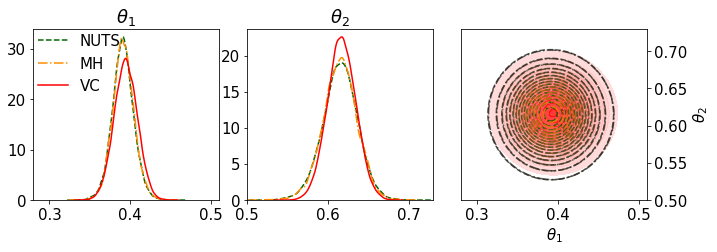

In [75]:
mean_theta = var_lambda_array[-1,:2] # First two elements are the mean
cov_theta = np.log(np.exp(var_lambda_array[-1,2:4]) + 1) # 3-4 are the transformed standard deviations
dim = 2
theta_variational = theta_prior = gaussian_mean_field_family(param = {"mu": mean_theta, "sigma": cov_theta}, dim = dim)

fig = plt.figure(figsize=(11, 3.5))
plt.rcParams.update({'font.size': 15})
gs = gridspec.GridSpec(1, 3)
n_levels = 20
bw = 0.030
bins = 50
alpha = 0.8
shade = False

ax = []
ax = ax + [plt.subplot(gs[0])]
ax = ax + [plt.subplot(gs[1])]
ax = ax + [plt.subplot(gs[2])]
plt.subplots_adjust(wspace = 0.15)

sns.distplot(trace_NUTS['theta'][25000:,0], bins = bins, ax = ax[0], label = 'NUTS', hist =False, color = "darkgreen", kde_kws={'linestyle':'--'})
sns.distplot(trace['theta'][25000:,0], bins = bins, ax = ax[0], label = 'MH', hist = False, color = "darkorange", kde_kws={'linestyle':'-.'})
sns.distplot(theta_variational.sample(25000)[:,0], bins = bins, ax = ax[0], label = 'VC', hist = False, color = "red", kde_kws={'linestyle':'-'})
ax[0].legend(frameon=False, bbox_to_anchor=(-0.05,1.05),loc = "upper left")
ax[0].title.set_text(r'$\theta_1$')

sns.distplot(trace_NUTS['theta'][25000:,1], bins = bins, ax = ax[1], hist =False, color = "darkgreen", kde_kws={'linestyle':'--'})
sns.distplot(trace['theta'][25000:,1], bins = bins, ax = ax[1],  hist = False, color = "darkorange", kde_kws={'linestyle':'-.'})
sns.distplot(theta_variational.sample(25000)[:,1], bins = bins, ax = ax[1], hist = False, color = "red", kde_kws={'linestyle':'-'})
ax[1].title.set_text(r'$\theta_2$')

sns.kdeplot(trace_NUTS['theta'][25000:,0], trace_NUTS['theta'][25000:,1], ax=ax[2], n_levels=n_levels, shade=shade, shade_lowest=shade, alpha = alpha, bw = bw, color = "darkgreen", label = 'NUTS', linestyles = '--')
sns.kdeplot(theta_variational.sample(25000)[:,0], theta_variational.sample(25000)[:,1], ax=ax[2], n_levels=n_levels,shade=True, shade_lowest=False, alpha = alpha, bw = bw, color = "red", label = 'VC')
sns.kdeplot(trace['theta'][25000:,0], trace['theta'][25000:,1], ax=ax[2], n_levels=n_levels, shade=shade, shade_lowest=shade, alpha = alpha, bw = bw, color = "darkorange", label = 'MH', linestyles = '-.')
ax[2].set_xlabel(r'$\theta_1$')
ax[2].set_ylabel(r'$\theta_2$')
ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
#ax[2].legend(frameon=False)

#AX lims
ax[2].set_xlim([0.28, 0.51])
ax[2].set_ylim([0.5, 0.73])

ax[0].set_xlim([0.28, 0.51])
ax[1].set_xlim([0.5, 0.73])

plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig("calibration_quality" + '.pdf', dpi=600)
plt.show()